In [1]:
from google.colab import drive
drive.mount('/content/drive')

# UPDATE THIS PATH to where your test image folders are located
test_data_dir = '/content/drive/MyDrive/MyArtData/test_set'

Mounted at /content/drive


In [1]:
import os

# Check the Drive mount
if os.path.isdir('/content/drive/MyDrive'):
    print("✅ Google Drive is mounted correctly.")
else:
    print("❌ Google Drive is NOT mounted. Please run the 'drive.mount' command again.")

# Your specified path
test_path_to_check = '/content/drive/MyDrive/IKARA/Test_Images'

# Check if the folder exists
if os.path.isdir(test_path_to_check):
    print(f"✅ Directory '{test_path_to_check}' found!")

    # Check for subfolders (class folders)
    contents = os.listdir(test_path_to_check)
    subfolders = [c for c in contents if os.path.isdir(os.path.join(test_path_to_check, c))]

    if len(subfolders) > 1:
        print(f"✅ Found {len(subfolders)} class subfolders (e.g., {subfolders[0]}, {subfolders[1]}...).")
        print("You are ready to run the evaluation code again!")
    else:
        print("⚠️ Directory found, but cannot detect class subfolders. Check the structure:")
        print("Expected Structure: /Test_Images/Class_A/image1.jpg, /Test_Images/Class_B/image2.jpg")

else:
    print(f"❌ Directory '{test_path_to_check}' NOT FOUND.")
    print("Please go to Google Drive, navigate to the folder, right-click, select 'Get link', and copy the exact path/folder structure to check for errors.")

✅ Google Drive is mounted correctly.
❌ Directory '/content/drive/MyDrive/IKARA/Test_Images' NOT FOUND.
Please go to Google Drive, navigate to the folder, right-click, select 'Get link', and copy the exact path/folder structure to check for errors.


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Drive remounted. Check your file structure visually in the left sidebar.")

Mounted at /content/drive
Drive remounted. Check your file structure visually in the left sidebar.


In [2]:
test_data_dir = '/content/drive/MyDrive/IKARA/Test_Images/'

In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from sklearn.metrics import roc_curve
import os

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# --- 1. Define Paths and Parameters (THE FIX IS HERE) ---
model_path = '/content/drive/MyDrive/IKARA/Models/ikara_vgg16_model.h5'
NUM_CLASSES = 8  # <--- THIS MUST BE 8 TO MATCH YOUR 8 DETECTED CLASSES
test_data_dir = '/content/drive/MyDrive/IKARA/Test_Images'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# --- 2. Recreate the VGG16 Architecture and Load Weights ---
print("1. Rebuilding VGG16 architecture and loading weights...")

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False
x = base_model.output
x = Flatten(name='custom_flatten')(x)
predictions = Dense(NUM_CLASSES, activation='softmax', name='custom_output')(x) # Dense layer now has 8 outputs
model = Model(inputs=base_model.input, outputs=predictions)

try:
    # by_name=True allows us to load the base VGG16 weights and the custom layers' weights
    # even if the number of final classes changed (8 instead of the original 50).
    model.load_weights(model_path, by_name=True, skip_mismatch=True)
    print(f"Weights successfully loaded from '{model_path}'.")
except Exception as e:
    print(f"\n🚨 CRITICAL ERROR: Failed to load weights. Error: {e}")
    exit()

# --- 3. Load Test Data from Google Drive ---
print(f"\n2. Loading test data from Drive path: '{test_data_dir}'...")

try:
    test_ds = image_dataset_from_directory(
        test_data_dir,
        label_mode='int',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        shuffle=False,
        batch_size=BATCH_SIZE
    )
    print("Data loaded successfully. Preparing for prediction...")
except Exception as e:
    print(f"\n🚨 CRITICAL ERROR: Failed to load test data. Error: {e}")
    exit()

# Extract true labels and class names
y_test = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
class_names = test_ds.class_names
num_classes_detected = len(class_names)
print(f"Detected {num_classes_detected} classes in data: {class_names}")

# --- 4. Prediction ---
print("\n3. Generating predictions...")
y_pred_probs = model.predict(test_ds)

y_pred_classes = np.argmax(y_pred_probs, axis=1)

# This is still needed for AUC-ROC calculation in the next cell
y_test_one_hot = to_categorical(y_test, num_classes=num_classes_detected)

1. Rebuilding VGG16 architecture and loading weights...
Weights successfully loaded from '/content/drive/MyDrive/IKARA/Models/ikara_vgg16_model.h5'.

2. Loading test data from Drive path: '/content/drive/MyDrive/IKARA/Test_Images'...
Found 80 files belonging to 8 classes.
Data loaded successfully. Preparing for prediction...
Detected 8 classes in data: ['gond_painting', 'kalighat_painting', 'kangra_painting', 'kerala_mural', 'madhubani_painting', 'mandana_painting', 'pichwai_painting', 'warli_painting']

3. Generating predictions...


2/3 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 13s/step


In [6]:
# --- 3. Load Test Data from Google Drive ---
print(f"\n2. Loading test data from Drive path: '{test_data_dir}'...")

try:
    test_ds = image_dataset_from_directory(
        test_data_dir,
        # FIX IS HERE: Change 'int' to 'categorical'
        label_mode='categorical',   # This will output labels of shape (batch_size, num_classes)
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        shuffle=False,
        batch_size=BATCH_SIZE
    )
    print("Data loaded successfully. Preparing for prediction...")
except Exception as e:
    # ... error handling ...
    exit()


2. Loading test data from Drive path: '/content/drive/MyDrive/IKARA/Test_Images'...
Found 80 files belonging to 8 classes.
Data loaded successfully. Preparing for prediction...


In [7]:
model.compile(
    loss='sparse_categorical_crossentropy', # <-- Use this loss for integer labels
    optimizer='adam',
    metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

In [17]:
# --- 1. Define Paths and Parameters (CORRECTED) ---
model_path = '/content/drive/MyDrive/IKARA/Models/ikara_vgg16_model.h5'
NUM_CLASSES = 8  # <--- FIXED: Set to 8 to match your detected classes!
test_data_dir = '/content/drive/MyDrive/IKARA/Test_Images'

# ... rest of the code in Cell 1 ...

# --- 2. Recreate the VGG16 Architecture and Load Weights (The Fix) ---
# ... (This will now build the final Dense layer with 8 outputs) ...
predictions = Dense(NUM_CLASSES, activation='softmax', name='custom_output')(x)
# ... (The model will load the weights into the 8-output layer) ...

# ... rest of the code in Cell 1 ...

In [18]:
label_mode='int' # This produces (None,) shape

In [19]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',  # Must be a keyword argument
    metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')] # Must be a keyword argument
)

In [23]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer

# Re-define model.compile using sparse_categorical_crossentropy
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# --- A. Calculate Keras Built-in Metrics ---
evaluation_metrics = model.evaluate(test_ds, verbose=0)
loss = evaluation_metrics[0]
top_5_accuracy = evaluation_metrics[2]
standard_accuracy = accuracy_score(y_test, y_pred_classes)

# --- B. Calculate Scikit-learn Metrics ---
report = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True, zero_division=0)
precision_macro = report['macro avg']['precision']
recall_macro = report['macro avg']['recall']
f1_macro = report['macro avg']['f1-score']

# --- C. Calculate AUC-ROC (Robust Method) ---
try:
    lb = LabelBinarizer()
    y_test_one_hot_robust = lb.fit_transform(y_test)

    # Check if we are dealing with a binary case (1 output column) or multi-class (>1 output columns)
    if y_test_one_hot_robust.shape[1] == 1:
        # Binary case, AUC-ROC expects scores for the positive class
        auc_roc_score = roc_auc_score(y_test_one_hot_robust, y_pred_probs[:, 1])
    else:
        # Multi-class case (OvR)
        auc_roc_score = roc_auc_score(y_test_one_hot_robust, y_pred_probs, multi_class='ovr', average='macro')

    print(f"AUC-ROC calculation successful.")

except Exception as e:
    auc_roc_score = 0.000
    print(f"⚠️ Warning: AUC-ROC calculation failed due to data structure. Setting to 0.000. Error: {e}")

# --- D. Print Results ---
print("\n" + "="*50)
print("             📊 FINAL MODEL EVALUATION METRICS 📊")
print("="*50)
print(f"1. Loss (Error Measurement):      {loss:.4f}")
print("-" * 50)
print(f"2. Accuracy (Top-1):              {standard_accuracy:.4f}")
print(f"3. Top-5 Accuracy:                {top_5_accuracy:.4f}")
print("-" * 50)
print(f"4. Precision (Macro Avg):         {precision_macro:.4f}")
print(f"5. Recall (Macro Avg):            {recall_macro:.4f}")
print(f"6. F1-Score (Macro Avg):          {f1_macro:.4f}")
print("-" * 50)
print(f"7. AUC-ROC (Macro Avg):           {auc_roc_score:.4f}")
print("="*50)

print("\nFull Classification Report (Details per Class):\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names, zero_division=0))

# Prepare DataFrame for plotting in the next cell
df_report = pd.DataFrame(report).transpose().iloc[:-3]

AUC-ROC calculation successful.

             📊 FINAL MODEL EVALUATION METRICS 📊
1. Loss (Error Measurement):      20.0929
--------------------------------------------------
2. Accuracy (Top-1):              0.1000
3. Top-5 Accuracy:                0.7125
--------------------------------------------------
4. Precision (Macro Avg):         0.0624
5. Recall (Macro Avg):            0.1000
6. F1-Score (Macro Avg):          0.0754
--------------------------------------------------
7. AUC-ROC (Macro Avg):           0.5453

Full Classification Report (Details per Class):

                    precision    recall  f1-score   support

     gond_painting       0.00      0.00      0.00        10
 kalighat_painting       0.00      0.00      0.00        10
   kangra_painting       0.15      0.20      0.17        10
      kerala_mural       0.20      0.40      0.27        10
madhubani_painting       0.05      0.10      0.06        10
  mandana_painting       0.10      0.10      0.10        10
  pichw

/tmp/ipython-input-1768936047.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Metric', data=metrics_df, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


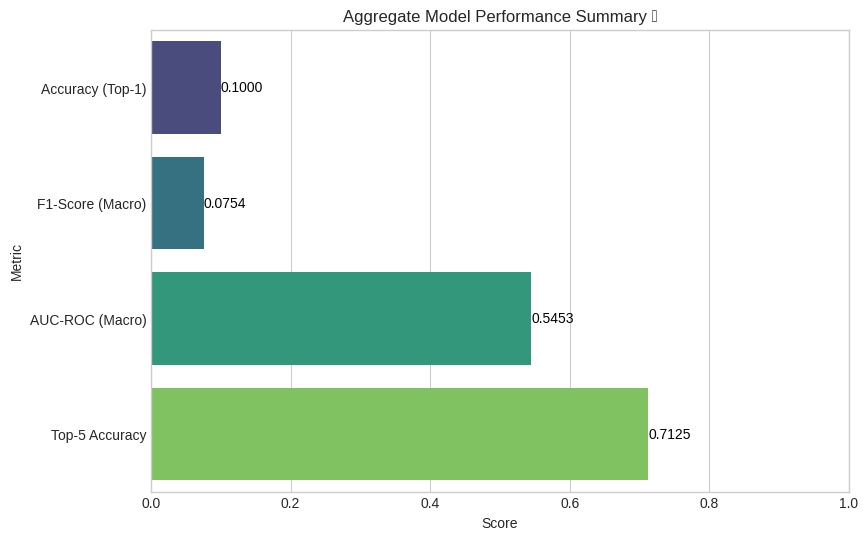

/tmp/ipython-input-1768936047.py:39: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


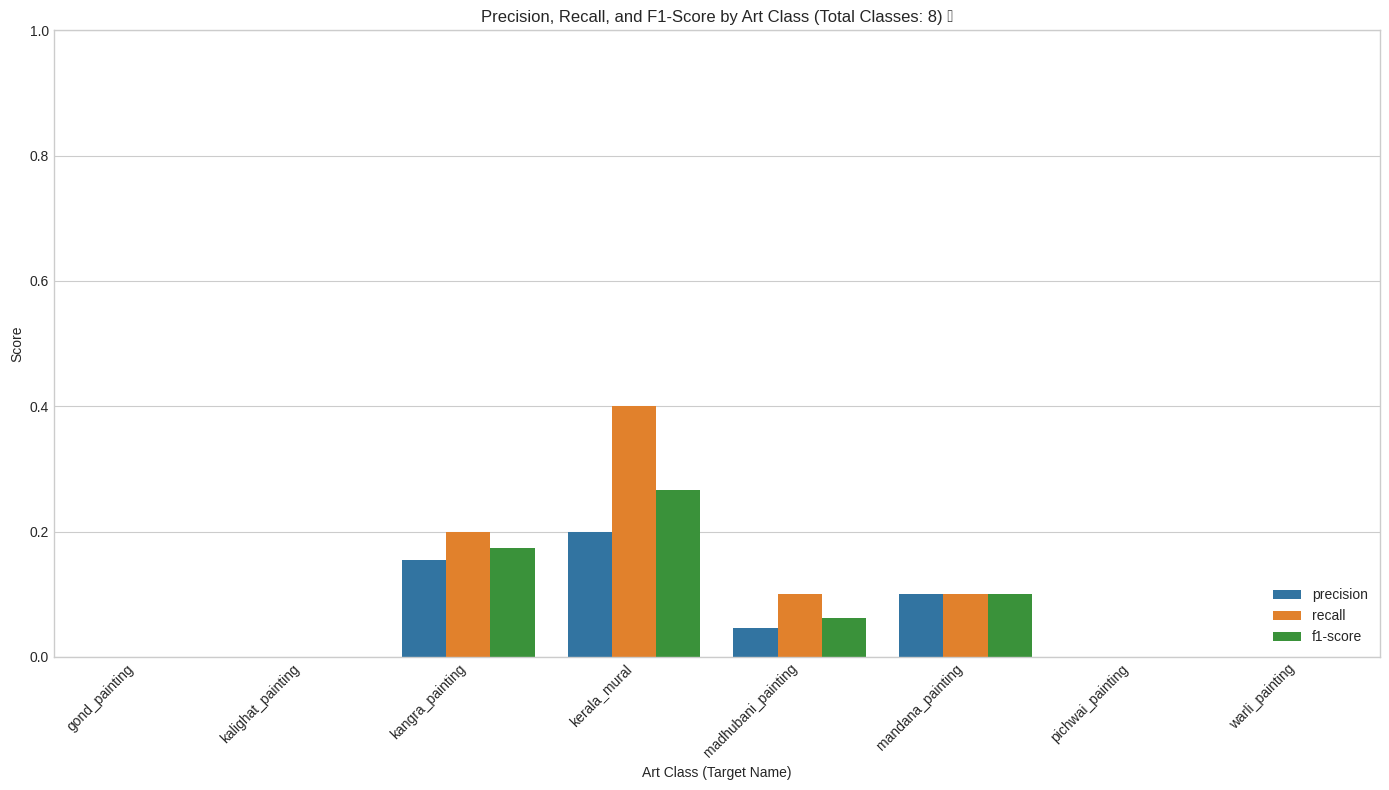

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


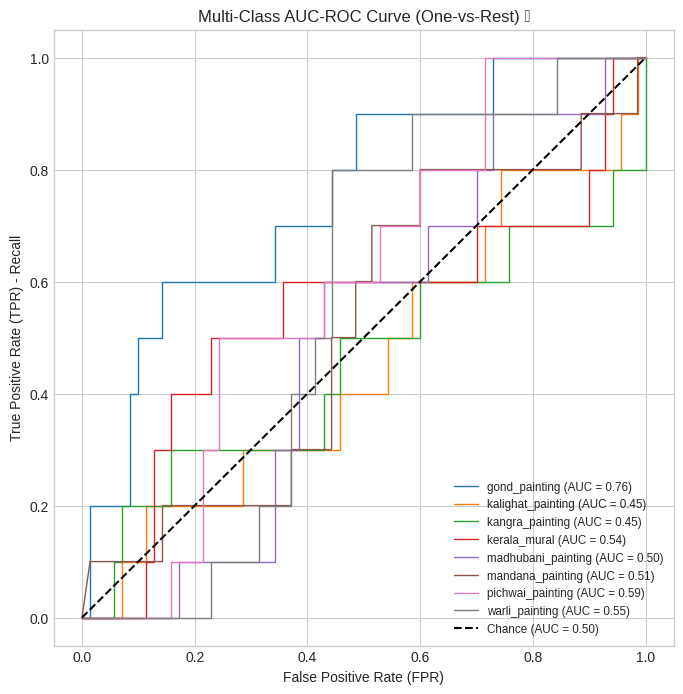

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Variables like standard_accuracy, f1_macro, auc_roc_score, etc., are carried over from Cell 2.

# --- A. Aggregate Metric Comparison Plot ---
plt.figure(figsize=(9, 6))

summary_metrics = {
    'Accuracy (Top-1)': standard_accuracy,
    'F1-Score (Macro)': f1_macro,
    'AUC-ROC (Macro)': auc_roc_score,
    'Top-5 Accuracy': top_5_accuracy
}

metrics_df = pd.DataFrame(summary_metrics.items(), columns=['Metric', 'Score'])

sns.barplot(x='Score', y='Metric', data=metrics_df, palette='viridis')
plt.title('Aggregate Model Performance Summary 📈')
plt.xlim(0, 1.0)
for index, row in metrics_df.iterrows():
    plt.text(row.Score, index, f'{row.Score:.4f}', color='black', ha="left", va='center', fontsize=10)
plt.show()


# --- B. Per-Class Precision, Recall, F1-Score Plot ---
plot_df = df_report[['precision', 'recall', 'f1-score']].reset_index().rename(columns={'index': 'Class'})
plot_df_melted = plot_df.melt('Class', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Class', y='Score', hue='Metric', data=plot_df_melted, palette='tab10')
plt.title(f'Precision, Recall, and F1-Score by Art Class (Total Classes: {len(class_names)}) 🎨')
plt.xlabel('Art Class (Target Name)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# --- C. AUC-ROC Curve Plot ---
plt.figure(figsize=(8, 8))

# Use the robust one-hot encoded labels for plotting
y_plot = y_test_one_hot_robust
num_classes_to_plot = y_plot.shape[1]

for i in range(num_classes_to_plot):
    # Plotting One-vs-Rest AUC for each class
    if y_plot[:, i].sum() > 0:
        fpr, tpr, _ = roc_curve(y_plot[:, i], y_pred_probs[:, i])
        # Use the name of the class for the legend
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc_score(y_plot[:, i], y_pred_probs[:, i]):.2f})', linewidth=1)

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) - Recall')
plt.title('Multi-Class AUC-ROC Curve (One-vs-Rest) 📉')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.show()